## Import packages

In [21]:
import math
import os

import numpy as np
import random
import librosa.display
import tensorflow_io as tfio
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from helperFunctions import create_dataset_df
import matplotlib.pyplot as plt

## Import dataset metadata

In [2]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-137.wav


## Feature Extraction and Data Augmentation functions
When analyzing the data, we found that our dataset contains different sampling frequencies, length, mono / stereo, etc.<br>
In order to classify the data using their spectrogram, we must unify them so that they have the same sampling frequency, length and number of channels.<br>

We will be using Mel-spectrogram for audio classification. If we were classifying speech and not general sounds, we would probably use MFCCs, which generally perform better in these kinds of tasks.<br>
Created spectrum is already one-sided, so we don´t need to cut of second half because of duplicate information. <br>
By default used window is *Hann Window*, and we will keep it this way.<br>

Regarding augmentation, the only one we apply is time shift. This will help CNN learn that, for example, a shot does not always have to be only in the first moments of the recording, which it would probably be learn, as most of the recordings (which I listened to) had a shot right at the beginning. <br>
Other augmentations that could help are masking the time and frequency in the spectrogram. <br>

In [3]:
CLASSES = 10
SAMPLE_RATE = 22050 #Hz
DURATION = 4 #s
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 64
TIME_BINS =  np.ceil(DURATION*SAMPLE_RATE/N_FFT*(N_FFT/HOP_LENGTH)).astype('int')
TIME_SHIFT_LIMIT = 0.5
TIME_MASKING_PARAM = np.round(TIME_BINS*0.1) # Up to 10% of time can be masked out
FREQ_MASKING_PARAM = np.round(N_MELS*0.2) # Up to 20% of Freqs can be masked out

def processing(filepath, class_id, augment=False):
    # Load audio as mono and resampled
    audio, sample_rate = librosa.load(filepath.numpy(),
                                      sr=SAMPLE_RATE,
                                      mono=True)

    # Make sure every signal has desired length
    audio = librosa.util.fix_length(audio,
                                    size= DURATION * SAMPLE_RATE)

    # Shift data by random amount to the right/left
    if augment:
        audio = time_shift(audio,
                            shift_limit=TIME_SHIFT_LIMIT)

    # Convert to freq domain. -> Mel Spectrum
    spec = mel_dB_spectrum(audio,
                                sr=SAMPLE_RATE,
                                n_fft=N_FFT,
                                hop_length=HOP_LENGTH,
                                n_mels=N_MELS)
    # Add Time and Freq masking
    if augment:
        spec = tfio.audio.freq_mask(np.transpose(spec), param=FREQ_MASKING_PARAM)
        spec = np.transpose(tfio.audio.time_mask(spec, param=TIME_MASKING_PARAM))

    x = np.reshape(spec, (N_MELS, TIME_BINS, 1))
    y = to_categorical(class_id, CLASSES)
    return x, y

def time_shift(audio, shift_limit):
    audio_len = audio.shape[0]
    shift_percentage = random.uniform(-1, 1) * shift_limit
    shift_amt = int(shift_percentage * audio_len)
    return np.roll(audio, shift_amt)

def mel_dB_spectrum(audio, sr, n_fft, hop_length, n_mels):
    mel = librosa.feature.melspectrogram(y=audio,
                                          sr=sr,
                                          n_fft=n_fft,
                                          hop_length=hop_length,
                                          n_mels=n_mels)
    return librosa.power_to_db(np.abs(mel))

def fixup_shape(data, labels):
    data.set_shape([N_MELS, TIME_BINS, 1])
    labels.set_shape([CLASSES])
    return data, labels

## Model Architecture

In [55]:
def create_model(features_size):
    model = Sequential()

    model.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                    strides=(2,2),
                    padding='same',
                    input_shape=features_size,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64,
                  kernel_size=(3,3),
                  strides=(2,2),
                  padding='same',
                  activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,
                    kernel_size=(2,2),
                    strides=(2,2),
                    padding='valid',
                    activation='relu'))

    model.add(Conv2D(filters=128,
                    kernel_size=(2,2),
                    strides=(2,2),
                    padding='valid',
                    activation='relu'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate= 0.001)

    model.compile(optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [56]:
model = create_model((N_MELS, TIME_BINS, 1))
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 32, 173, 64)       1664      
                                                                 
 dropout_49 (Dropout)        (None, 32, 173, 64)       0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 86, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 8, 43, 64)         36928     
                                                                 
 dropout_50 (Dropout)        (None, 8, 43, 64)         0         
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 4, 21, 64)        0         
 g2D)                                                

## Dataset split

We should use Kfold cross validation, but as part of speeding up and demonstrating the principle, we will do it as follows:

- For training we will use folds 1-9
- For validating we will use fold 10


In [57]:
BATCH_SIZE = 32

### Training Dataset

In [58]:
def create_training_dataset(dataframe):
    return  tf.data.Dataset.from_tensor_slices((dataframe["filepath"], dataframe["classID"]))\
                    .map(lambda filepath, class_id: tf.py_function(processing,
                                                  inp=[filepath, class_id, True],
                                                  Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .map(fixup_shape,
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .batch(BATCH_SIZE)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .shuffle(len(dataframe)//BATCH_SIZE)\
                    .repeat()


In [8]:
train_df = dataset_df.loc[dataset_df["fold"] < 10]

train_dataset = create_training_dataset(train_df)

       slice_file_name    fsID  start  end  salience  fold  classID  \
3451  171184-9-0-6.wav  171184    3.0  7.0         2     7        9   

             class                                   filepath  
3451  street_music  UrbanSound8K/audio\fold7\171184-9-0-6.wav  


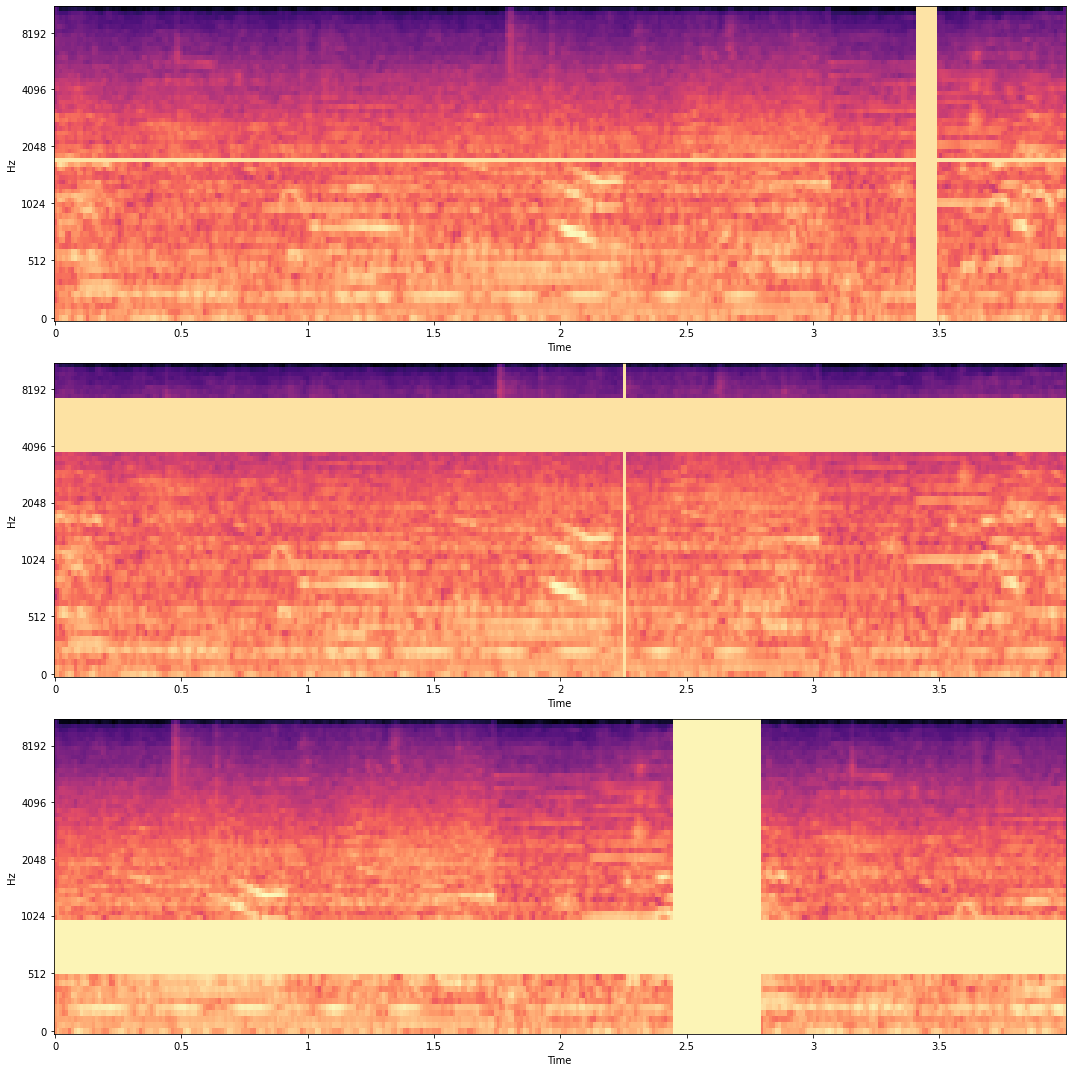

In [9]:
df = train_df.sample(1)
print(df)
#Create dataset, this will return object of TensorSliceDataset
dataset = tf.data.Dataset.from_tensor_slices((df["filepath"], df["classID"]))\
                    .map(lambda filepath, class_id: tf.py_function(processing,
                                                  inp=[filepath, class_id, True],
                                                  Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .map(fixup_shape,
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .repeat()\
                    .cache()\
                    .prefetch(tf.data.AUTOTUNE)\



# Visualize the Mel-Spectograms
fig, axs = plt.subplots(3, figsize=(15,15))
row = 0
for data, label in dataset:
        data = np.reshape(data.numpy(),(N_MELS, TIME_BINS))
        spec = librosa.display.specshow(data,
                                        sr=SAMPLE_RATE,
                                        hop_length=HOP_LENGTH,
                                        x_axis="time",
                                        y_axis='mel',
                                        ax=axs[row])
        row += 1
        if row == 3:
            break

fig.tight_layout()

### Validation Dataset

In [15]:
def create_validation_dataset(dataframe):
    return tf.data.Dataset.from_tensor_slices((dataframe["filepath"], dataframe["classID"]))\
                    .map(lambda filepath, class_id: tf.py_function(processing,
                                                  inp=[filepath, class_id],
                                                  Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .map(fixup_shape,
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .cache()\
                    .batch(BATCH_SIZE)\
                    .prefetch(tf.data.AUTOTUNE)

In [16]:
valid_df = dataset_df.loc[dataset_df["fold"] == 10]

valid_dataset = create_validation_dataset(valid_df)

## Training
Because we basically converted sound recognition tasks to image recognition (spectrogram).I recommend training the model for several iterations by generating new (augmented) training data before each training session. Time shifting really helps with generalizing od the model. If you want to futher generalize model, you can apply another augmentation such as frequency and/or time masking on the spectrogram.<br>
Training the model should not take long. Since I don't have a GPU, I trained it on a CPU (11th Gen Intel (R) Core (TM) i7-1165G7 @ 2.80GHz 2.80 GHz), where training of 20 epochs took about 25-30 minutes.


### Model saving

In [12]:
checkpoint_path = "models/acusticEvents-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epoch
model_save_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=len(train_df)//BATCH_SIZE)

### Clean training
After twenty epochs of training on a clean (without precomputed weights) model, we achieved:

- Training data accuracy **90%**
- Validation data accuracy **84%**

Which is really not so bad considering diversity of the dataset.

In [218]:
history = model.fit(train_dataset,
              validation_data=valid_dataset,
              validation_steps=len(valid_df)//BATCH_SIZE,
              steps_per_epoch=len(train_df)//BATCH_SIZE,
              epochs=20,
              callbacks=[model_save_callback])

Epoch 1/20
245/246 [============================>.] - ETA: 1s - loss: 2.3617 - accuracy: 0.1329
Epoch 1: saving model to models\acusticEvents-0001.ckpt
246/246 [==============================] - 762s 2s/step - loss: 2.3611 - accuracy: 0.1330 - val_loss: 2.2410 - val_accuracy: 0.1502
Epoch 2/20
245/246 [============================>.] - ETA: 1s - loss: 2.1462 - accuracy: 0.2046
Epoch 2: saving model to models\acusticEvents-0002.ckpt
246/246 [==============================] - 370s 2s/step - loss: 2.1460 - accuracy: 0.2051 - val_loss: 2.0083 - val_accuracy: 0.2596
Epoch 3/20
245/246 [============================>.] - ETA: 1s - loss: 1.9929 - accuracy: 0.2811
Epoch 3: saving model to models\acusticEvents-0003.ckpt
246/246 [==============================] - 372s 2s/step - loss: 1.9937 - accuracy: 0.2806 - val_loss: 1.7991 - val_accuracy: 0.3125
Epoch 4/20
245/246 [============================>.] - ETA: 1s - loss: 1.8118 - accuracy: 0.3466
Epoch 4: saving model to models\acusticEvents-0004.c

In [80]:
model = create_model((128, 173, 1))

for i in range(30):
    if i != 0:
        model.load_weights(f"models/acusticEvents-{best_epoch+1:04d}.ckpt")

    train_dataset = create_training_dataset(train_df)
    history = model.fit(train_dataset,
              validation_data=valid_dataset,
              validation_steps=len(valid_df)//BATCH_SIZE,
              steps_per_epoch=len(train_df)//BATCH_SIZE,
              epochs=15,
              callbacks=[model_save_callback])
    best_epoch = np.argmax(history.history["val_accuracy"])

Epoch 1/15
246/246 [==============================] - ETA: 0s - loss: 2.3374 - accuracy: 0.1731
Epoch 00001: saving model to models\acusticEvents-0001.ckpt
246/246 [==============================] - 316s 1s/step - loss: 2.3374 - accuracy: 0.1731 - val_loss: 2.1389 - val_accuracy: 0.2788
Epoch 2/15
246/246 [==============================] - ETA: 0s - loss: 2.0819 - accuracy: 0.2563
Epoch 00002: saving model to models\acusticEvents-0002.ckpt
246/246 [==============================] - 52s 211ms/step - loss: 2.0819 - accuracy: 0.2563 - val_loss: 1.9623 - val_accuracy: 0.3954
Epoch 3/15
246/246 [==============================] - ETA: 0s - loss: 1.9526 - accuracy: 0.3238
Epoch 00003: saving model to models\acusticEvents-0003.ckpt
246/246 [==============================] - 51s 207ms/step - loss: 1.9526 - accuracy: 0.3238 - val_loss: 1.8911 - val_accuracy: 0.3197
Epoch 4/15
246/246 [==============================] - ETA: 0s - loss: 1.7704 - accuracy: 0.3642
Epoch 00004: saving model to models\

In [66]:
print(f"models/acusticEvents-{best_epoch+1:04d}.ckpt")

models/acusticEvents-0001.ckpt


### Training from checkpoint
During several other iterations, where the model weights were based on the best epoch of the previous iteration, the model achieved:

- Training data accuracy **96%**
- Validation data accuracy **95%**

Before each iteration, I generated new training data, which enables the model to gradually generalize.<br>


In [ ]:
model.load_weights('models/acusticEvents-0020.ckpt')
history = model.fit(train_dataset,
          validation_data=valid_dataset,
          validation_steps=len(valid_df)//BATCH_SIZE,
          steps_per_epoch=len(train_df)//BATCH_SIZE,
          epochs=50,
          callbacks=[model_save_callback])

Epoch 1/50
245/246 [============================>.] - ETA: 1s - loss: 0.7846 - accuracy: 0.7322
Epoch 1: saving model to models\acusticEvents-0001.ckpt
246/246 [==============================] - 722s 1s/step - loss: 0.7852 - accuracy: 0.7320 - val_loss: 1.1499 - val_accuracy: 0.6767
Epoch 2/50
245/246 [============================>.] - ETA: 1s - loss: 0.7624 - accuracy: 0.7458
Epoch 2: saving model to models\acusticEvents-0002.ckpt
246/246 [==============================] - 363s 1s/step - loss: 0.7659 - accuracy: 0.7442 - val_loss: 1.1499 - val_accuracy: 0.6659
Epoch 3/50
245/246 [============================>.] - ETA: 1s - loss: 0.7742 - accuracy: 0.7359
Epoch 3: saving model to models\acusticEvents-0003.ckpt
246/246 [==============================] - 363s 1s/step - loss: 0.7733 - accuracy: 0.7364 - val_loss: 1.1882 - val_accuracy: 0.6466
Epoch 4/50
245/246 [============================>.] - ETA: 1s - loss: 0.7195 - accuracy: 0.7551
Epoch 4: saving model to models\acusticEvents-0004.c

In [18]:
results = []
for i in range(1,50):
    model.load_weights(f'models/acusticEvents-{i:04d}.ckpt')
    temp_result = model.evaluate(valid_dataset)
    results.append(temp_result)

27/27 [==============================] - 0s 12ms/step - loss: 1.2325 - accuracy: 0.7324
